In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from unet import Unet
import gc

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


def dice_coefficient(pred, target):
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + 1) / (pred.sum() + target.sum() + 1)
    return dice


def dice_loss(pred, target):
    return 1 - dice_coefficient(pred, target)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 2e-4
nepochs = 5
# TODO: adjust these values and don't run out of memory
bs = 1
n = 500

model = Unet(input_channel=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = dice_loss

d = np.load("d.npy", allow_pickle=True).item()
imgs = d["imgs"]
masks = d["masks"]

# Normalize to [0, 255]
imgs = torch.tensor(
    np.round(
        (imgs - imgs.min(axis=(1, 2))[:, None, None])
        / (imgs.max(axis=(1, 2)) - imgs.min(axis=(1, 2)))[:, None, None]
        * 255
    )
).float()
masks = torch.tensor(masks).long()

imgs = imgs[:n]
masks = masks[:n]

# Add one color channel dimension to all the images
imgs = imgs.unsqueeze(1)

train_dataset, test_dataset = torch.utils.data.random_split(
    list(zip(imgs, masks)), [int(np.ceil(n * 0.8)), int(np.floor(n * 0.2))]
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)

for epoch in range(nepochs):
    model.train()
    for i, (img, mask) in enumerate(train_dataloader):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        print(
            f"Epoch {epoch+1}/{nepochs}, iteration {i}/{len(train_dataloader)}, loss: {loss.item()}"
        )

    model.eval()
    for i, (img, mask) in enumerate(test_dataloader):
        img, mask = img.to(device), mask.to(device)
        output = model(img)
        loss = criterion(output, mask)
        print(
            f"Epoch {epoch+1}/{nepochs}, iteration {i}/{len(test_dataloader)}, loss: {loss.item()}"
        )

Epoch 1/5, iteration 0/400, loss: 0.9968980550765991
Epoch 1/5, iteration 1/400, loss: 0.9998328685760498
Epoch 1/5, iteration 2/400, loss: 0.9961408376693726
Epoch 1/5, iteration 3/400, loss: 0.9986811280250549
Epoch 1/5, iteration 4/400, loss: 0.9977549314498901
Epoch 1/5, iteration 5/400, loss: 0.9996430277824402
Epoch 1/5, iteration 6/400, loss: 0.9999030828475952
Epoch 1/5, iteration 7/400, loss: 0.9939893484115601
Epoch 1/5, iteration 8/400, loss: 0.9971985220909119
Epoch 1/5, iteration 9/400, loss: 0.9999245405197144
Epoch 1/5, iteration 10/400, loss: 0.9970757365226746
Epoch 1/5, iteration 11/400, loss: 0.9964641332626343
Epoch 1/5, iteration 12/400, loss: 0.9971364736557007
Epoch 1/5, iteration 13/400, loss: 0.9980430603027344
Epoch 1/5, iteration 14/400, loss: 0.9997387528419495
Epoch 1/5, iteration 15/400, loss: 0.9982130527496338
Epoch 1/5, iteration 16/400, loss: 0.9986442923545837
Epoch 1/5, iteration 17/400, loss: 0.9994076490402222
Epoch 1/5, iteration 18/400, loss: 0.9

/home/hxwk/ai/projekt/venv/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 290.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/hxwk/ai/projekt/venv/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 434.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/hxwk/ai/projekt/venv/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internall

Epoch 4/5, iteration 0/400, loss: 0.9715254306793213
Epoch 4/5, iteration 1/400, loss: 0.12498188018798828
Epoch 4/5, iteration 2/400, loss: 0.17511045932769775
Epoch 4/5, iteration 3/400, loss: 0.21868187189102173
Epoch 4/5, iteration 4/400, loss: 0.2686840295791626
Epoch 4/5, iteration 5/400, loss: 0.990928053855896
Epoch 4/5, iteration 6/400, loss: 0.27239030599594116
Epoch 4/5, iteration 7/400, loss: 0.19569462537765503
Epoch 4/5, iteration 8/400, loss: 0.13256299495697021
Epoch 4/5, iteration 9/400, loss: 0.28052181005477905
Epoch 4/5, iteration 10/400, loss: 0.11561006307601929
Epoch 4/5, iteration 11/400, loss: 0.1964867115020752
Epoch 4/5, iteration 12/400, loss: 0.2558908462524414
Epoch 4/5, iteration 13/400, loss: 0.15182697772979736
Epoch 4/5, iteration 14/400, loss: 0.14696520566940308
Epoch 4/5, iteration 15/400, loss: 0.07882142066955566
Epoch 4/5, iteration 16/400, loss: 0.1177639365196228
Epoch 4/5, iteration 17/400, loss: 0.260425329208374
Epoch 4/5, iteration 18/400, 

In [2]:
torch.save(model.state_dict(), "./model-5epoch-500img.pth")

In [ ]:
model = Unet(input_channel=1).to(device)
model.load_state_dict(torch.load("./model-5epoch-500img.pth"))

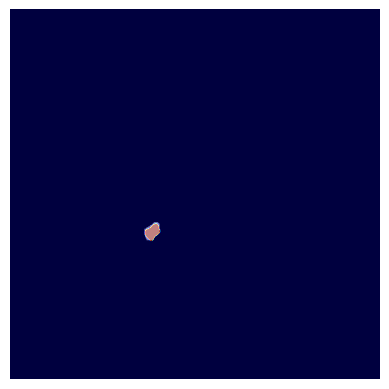

In [27]:
from torch import tensor

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


n = 1500
img = tensor(d["imgs"][n]).float()
mask = tensor(d["masks"][n]).long()

# Normalize to [0, 255]
img = np.round((img - img.min()) / (img.max() - img.min()) * 255)
img = img.unsqueeze(0).unsqueeze(0)

model.eval()
pred_mask = model(img.to(device)).detach().cpu()

plt.axis("off")
plt.imshow(mask, cmap="gray")
plt.imshow(pred_mask[0, 0], alpha=0.5, cmap="jet")
plt.savefig("pred.png")